<a href="https://colab.research.google.com/github/Alijgh003/StyleMind-GNN/blob/main/StyleMind_GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import matplotlib.pyplot as plt
import copy
import pandas as pd

In [2]:
torch_version = str(torch.__version__)
# scatter_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
# sparse_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
# !pip install torch-scatter -f $scatter_src
# !pip install torch-sparse -f $sparse_src
!pip install torch-geometric
!pip install -q git+https://github.com/snap-stanford/deepsnap.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.5 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
datasets_path = "/content/drive/MyDrive/StyleMind-GNN"

In [3]:
from os import path

In [4]:
import pandas as pd
items = pd.read_csv(path.join(datasets_path, "new_items.csv"))
items.set_index("ID")

,Unnamed: 0,index,url_name,description,catgeories,title,related,category_id,semantic_category,name_len
ID,,,,,,,,,,
211990161,0,0,neck print chiffon plus size,NaN,NaN,NaN,NaN,3,tops,28
183179503,1,1,christian pellizzari floral jacquard trousers,Gold and black silk blend floral jacquard trou...,"[""Women's Fashion"", 'Clothing', 'Pants', 'Chri...",Christian Pellizzari floral jacquard trousers,"['Floral pants', 'Grey pants', 'Print pants', ...",2,bottoms,45
152771755,2,2,natures jewelry stainless steel not,NaN,NaN,NaN,NaN,11,jewellery,35
190445143,3,3,balmain women high waist flared,Decorative gold colored buttons with lion deta...,"[""Women's Fashion"", 'Clothing', 'Pants', 'Balm...",Balmain Women High Waist Flared Knit Pants,"['Balmain', 'Flared pants', 'High-waisted pant...",2,bottoms,31
211444470,4,4,acler orson high waist belted,This Acler Orson High Waist Belted Short featu...,"[""Women's Fashion"", 'Clothing', 'Shorts', 'Mar...",Acler Orson High Waist Belted Short,"['Short shorts', 'High-waisted shorts', 'High ...",2,bottoms,29
...,...,...,...,...,...,...,...,...,...,...
108411005,251003,251003,arnica embellished hand painted skirt,Shop Stella Jean in our expertly curated in-se...,"[""Women's Fashion"", 'Clothing', 'Skirts', 'Kne...",Arnica Embellished Hand Painted Skirt,"['Red skirt', 'Embellished skirt']",2,bottoms,37
212452593,251004,251004,thom browne little boy knitted,NaN,NaN,NaN,NaN,4,outerwear,30
208651882,251005,251005,colorful vortex print shawl scarf,NaN,NaN,NaN,NaN,8,scarves,33


#Utils

##Histoagram

In [5]:
def plot_histogram(output_tensor,title):
  output_numpy = output_tensor.detach().numpy()

  plt.hist(output_numpy, bins=30, edgecolor='black', alpha=0.7)
  plt.xlabel('Output Values')
  plt.ylabel('Frequency')
  plt.title(title)
  plt.show()

##Free Cuda_Memory

In [6]:
import gc

def free_cuda_memory(model):
  model = model.cpu()
  gc.collect()
  torch.cuda.empty_cache()

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [8]:
x = torch.load(path.join(datasets_path, "items_img2vec.pth")).to(device)
x, x.shape

(tensor([[0.2134, 0.4643, 0.3334,  ..., 0.3668, 0.0379, 0.0898],
         [0.5982, 0.7184, 0.2694,  ..., 0.2122, 0.6592, 0.0720],
         [0.3819, 4.5064, 0.2355,  ..., 0.2252, 0.7095, 0.4182],
         ...,
         [0.0192, 0.2306, 0.6947,  ..., 0.2099, 0.2533, 0.1645],
         [0.4130, 0.2520, 0.2924,  ..., 0.5590, 0.3986, 0.0838],
         [0.0576, 1.2712, 1.8085,  ..., 0.6934, 0.9322, 0.0889]],
        device='cuda:0'),
 torch.Size([251008, 2048]))

In [9]:
x.dtype ,x.shape

(torch.float32, torch.Size([251008, 2048]))

In [10]:
edge_indices_path = path.join(datasets_path, "dataset", "polyvore_outfits", "nondisjoint")

In [11]:
train_edge_index = torch.load(path.join(edge_indices_path, "train_edge_index.pth"))
test_edge_index = torch.load(path.join(edge_indices_path, "test_edge_index.pth"))
valid_edge_index = torch.load(path.join(edge_indices_path, "valid_edge_index.pth"))

In [12]:
train_edge_index.shape, valid_edge_index.shape, test_edge_index.shape

(torch.Size([53306, 2, 171]),
 torch.Size([5000, 2, 91]),
 torch.Size([10000, 2, 136]))

In [13]:
negative_train_edge_index = torch.load(path.join(edge_indices_path,"negative_train_edge_index.pth"))

negative_train_edge_index.shape

torch.Size([53306, 2, 171])

In [14]:
def get_node_embedding_with_mask_meaningless_edge_index_elements(x, edge_index):
  mask = torch.where(edge_index==-1, torch.tensor(0), torch.tensor(1)).unsqueeze(-1)
  r = x[edge_index] * mask
  return r

In [15]:
def concat_edge_indices(edge_index_tensor_by_groups):
  result = torch.cat([edge_index_tensor_by_groups[i] for i in range(edge_index_tensor_by_groups.shape[0])],dim=-1)
  result = result[:,torch.where(result[0]>-1)[0]]
  return result

In [16]:
concat_edge_indices(train_edge_index[:1])

tensor([[204439, 154376, 154376, 154376, 154376, 154376, 154376, 154376, 191980,
         191980, 191980, 192270, 192270, 192270, 192270,   6713,   6713,  78057,
          78057,  78057,  78057,  78057, 100757, 100757, 100757, 100757, 100757,
         100757],
        [249298, 249298, 204439, 191980, 192270,   6713,  78057, 100757, 249298,
         204439,   6713, 249298, 204439, 191980,   6713, 249298, 204439, 249298,
         204439, 191980, 192270,   6713, 249298, 204439, 191980, 192270,   6713,
          78057]])

In [17]:
x.shape

torch.Size([251008, 2048])

In [18]:
from torch import nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv,MessagePassing
from torch_geometric.utils import to_undirected

import torch.optim as optim

In [19]:
class MyGCNMLP(MessagePassing):
  def __init__(self,in_channels, out_channels):
    super(MyGCNMLP, self).__init__()

    self.lin = torch.nn.Linear(in_channels, out_channels)


  def forward(self, x, edge_index):
    return self.lin(x)

In [38]:
class StyleMindGCN(nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels ,number_of_layers, model_type="GCN" , dropout=0.5, learning_margin=False):
    super(StyleMindGCN,self).__init__()

    self.convs = torch.nn.ModuleList([self.get_model(model_type)(in_channels if i==0 else hidden_channels,hidden_channels if i<number_of_layers-1 else out_channels, bias=False if i<number_of_layers-1 else True) for i in range(number_of_layers)])
    self.bns = torch.nn.ModuleList([torch.nn.BatchNorm1d(hidden_channels) for i in range(number_of_layers-1)])

    self.learning_margin = learning_margin
    if self.learning_margin:
      self.final_prediction_margin = torch.nn.Parameter(torch.tensor(0.0))
    else:
      self.final_prediction_margin = torch.tensor(0.0)

    self.dropout = dropout


  def reset_parameters(self):
    for conv in self.convs:
        conv.reset_parameters()
    for bn in self.bns:
        bn.reset_parameters()


  def get_model(self, model_type):
    if(model_type=="GAT"):
      return GATConv
    elif(model_type=="MLP"):
      return MyGCNMLP

    else:
      return GCNConv

  def forward(self, x, edge_index, outfits):
    # x is the tensor of node_features (i.e. ResNet representation of each image of each garment)
    # edge_index is the (2, |E|) to represent edges between garments
    # outfits are 3 dim tensors with shape of (|O|, 2 , |Maximum combination of garments in the outfits in dataset|)
    edge_index = to_undirected(edge_index)

    for conv, bn in zip(self.convs[:-1], self.bns):
      x = conv(x, edge_index)
      x = bn(x)
      x = F.relu(x)
      x = F.dropout(x, self.dropout)

    x = self.convs[-1](x,edge_index)

    o = get_node_embedding_with_mask_meaningless_edge_index_elements(x,outfits)
    # the output will be in the shape of (|O|, 2, |Maximum combination of garments in the outfits in dataset|)
    # o = (F.cosine_similarity(o[:,0,:].squeeze(1), o[:,1,:].squeeze(1),dim=-1)).sum(dim=-1) / (outfits[:,:1,:]>=0).float().sum(dim=(-1,-2))
    o = (o[:,0,:] * o[:,1,:]).sum(dim=(-1,-2)) / (outfits[:,:1,:]>=0).float().sum(dim=(-1,-2))
    # the output will be in the shape of |O|
    # o = F.sigmoid(o)
    return x, o+self.final_prediction_margin


In [22]:
torch.sigmoid(torch.tensor(-1))

tensor(0.2689)

In [23]:
def train(model, x, edge_index, outfits, labels, optimizer, loss_fn):
  model.train()
  optimizer.zero_grad()
  embds,o = model(x, edge_index, outfits)

  loss = loss_fn(o, labels)
  loss.backward()

  optimizer.step()

  return loss.item()

In [24]:
@torch.no_grad()
def test(model, x, edge_index, outfits, labels, decision_boundary=0.5):
  model.eval()

  embds,o = model(x, edge_index, outfits)
  o = torch.sigmoid(o)
  o_pred = torch.where(o>=decision_boundary, torch.tensor(1), torch.tensor(0))

  acc = (o_pred==labels).float().sum() / o_pred.shape[0]

  return  acc

In [25]:
in_channels = x.shape[-1]
hidden_channels = 128
out_channels = 128
lr = 0.01
number_of_layers = 3
dropout = 0.5

In [26]:
model = StyleMindGCN(in_channels, hidden_channels
                     ,out_channels, number_of_layers,"GCN", dropout, learning_margin=True).to(device)

In [27]:
NUM_EPOCHS = 500

# TODO:
- [x] splitting train dataset to two part
      - message_passing
      - labels
- [x] negative sampling  
  naive negative sampling: We just have randomly selected
    8 nodes to combine(2,nodes) to create some negative samples

In [28]:
%%time
def split_train_data(train_edge_index, diameter=8):
  edge_nums =  train_edge_index.shape[0]
  random_permutation = torch.randperm(edge_nums)
  eval_outfits = train_edge_index[random_permutation[:edge_nums//diameter]]
  message_passing_edges = concat_edge_indices(train_edge_index[random_permutation[edge_nums//diameter:]])
  return eval_outfits, message_passing_edges

a = split_train_data(train_edge_index)
[value.shape for  value in a]

CPU times: user 249 ms, sys: 178 ms, total: 427 ms
Wall time: 425 ms


[torch.Size([6663, 2, 171]), torch.Size([2, 599963])]

# Naive negative sampling

In [29]:
%%time
import torch
import itertools

def create_random_negative_samples(num_set, num_samples, num_garment, padding_size):
  combinations = [[list(itertools.combinations(torch.randperm(x.shape[0])[:num_garment].tolist(), 2)) for i in range(num_samples)] for j in range(num_set)]

  tensor = torch.tensor(combinations).transpose(-1,-2)
  tensor = torch.cat((tensor.flip(-2), tensor), dim=-1)
  result = torch.full((num_set, num_samples, 2, padding_size), -1)
  result[:,:,:,:tensor.shape[-1]] = tensor
  return result

# negative_samples = create_random_negative_samples(10, 5000, 8, train_edge_index.shape[-1])
# negative_samples.shape

CPU times: user 5 µs, sys: 3 µs, total: 8 µs
Wall time: 10.5 µs


In [30]:
valid_negative_samples = create_random_negative_samples(1, valid_edge_index.shape[0],8, valid_edge_index.shape[-1])[0]
test_negative_samples = create_random_negative_samples(1, test_edge_index.shape[0],8, test_edge_index.shape[-1])[0]
valid_negative_samples.shape, test_negative_samples.shape

(torch.Size([5000, 2, 91]), torch.Size([10000, 2, 136]))

# untrained model behaviour

In [48]:
train_positives_eval_outfits, message_passing_edges = split_train_data(train_edge_index, 5)
train_negatives_eval_outfits = negative_train_edge_index[torch.randperm(negative_train_edge_index.shape[0])[:train_positives_eval_outfits.shape[0]]]
train_labels = torch.cat((torch.ones(train_positives_eval_outfits.shape[0]),
                          torch.zeros(train_negatives_eval_outfits.shape[0])))
eval_outfits = torch.cat((train_positives_eval_outfits,train_negatives_eval_outfits), dim=0)

embd, o = model(x.to(device), message_passing_edges.to(device), eval_outfits.to(device))
embd = embd.to("cpu")
o = o.to("cpu")

OutOfMemoryError: CUDA out of memory. Tried to allocate 3.48 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.79 GiB is free. Process 4495 has 11.95 GiB memory in use. Of the allocated memory 8.58 GiB is allocated by PyTorch, and 3.25 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

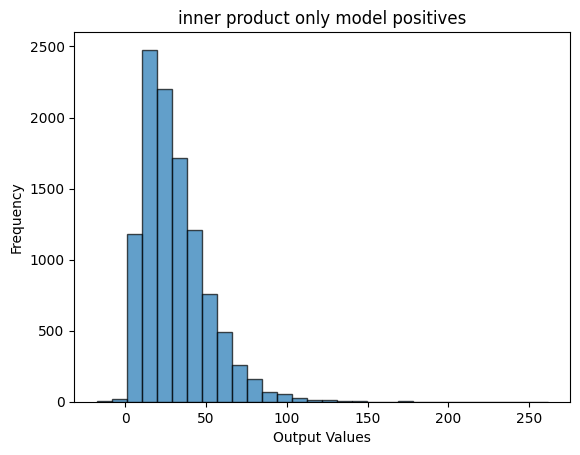

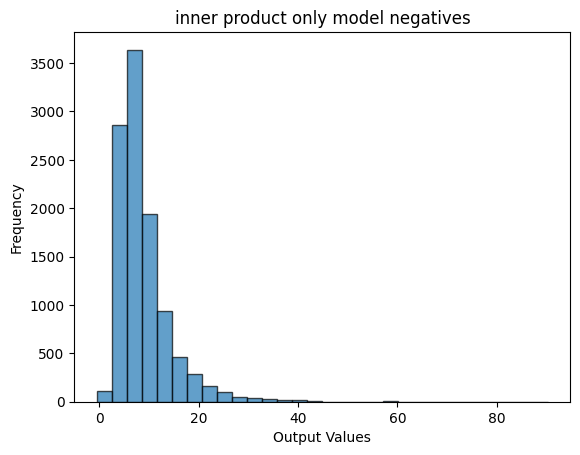

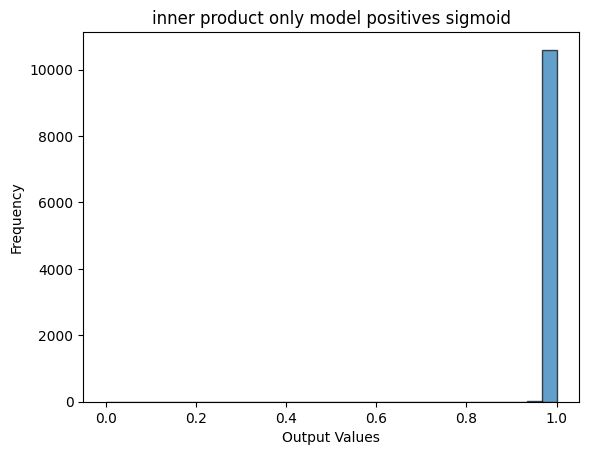

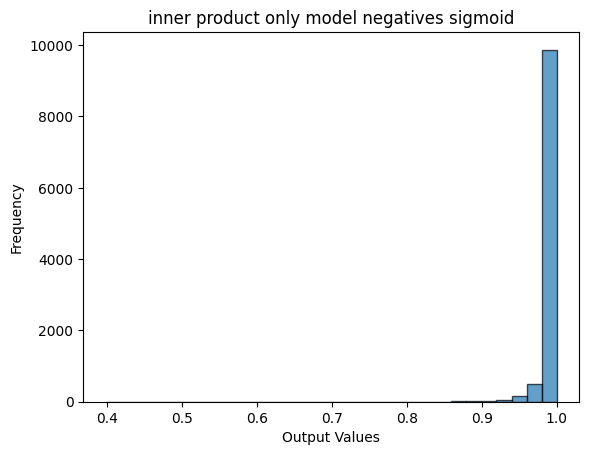

In [39]:
plot_histogram(o[:o.shape[0]//2], "inner product only model positives")
plot_histogram(o[o.shape[0]//2:], "inner product only model negatives")
plot_histogram(torch.sigmoid(o[:o.shape[0]//2]), "inner product only model positives sigmoid")
plot_histogram(torch.sigmoid(o[o.shape[0]//2:]), "inner product only model negatives sigmoid")

In [ ]:
model.reset_parameters()

optimizer = optim.Adam(model.parameters(), lr)
loss_fn = nn.BCELoss()

x = x.to(device)
for epoch in range(NUM_EPOCHS):

    train_positives_eval_outfits, message_passing_edges = split_train_data(train_edge_index, 8)
    train_negatives_eval_outfits = negative_samples[epoch % negative_samples.shape[0]]
    train_labels = torch.cat((torch.ones(train_positives_eval_outfits.shape[0]),
                              torch.zeros(train_negatives_eval_outfits.shape[0])))
    train_eval_outfits = torch.cat((train_positives_eval_outfits, train_negatives_eval_outfits), dim=0)
    train_loss = train(model, x, message_passing_edges.to(device)
    , train_eval_outfits.to(device), train_labels.to(device),
                       loss_fn=loss_fn, optimizer=optimizer)
    train_acc = test(model, x, message_passing_edges.to(device)
    , train_eval_outfits.to(device), train_labels.to(device))


    valid_message_passing_edges = torch.cat((concat_edge_indices(train_positives_eval_outfits)
    , message_passing_edges), dim=-1)
    valid_labels = torch.cat((torch.ones(valid_edge_index.shape[0]),
                              torch.zeros(valid_negative_samples.shape[0])))
    valid_eval_outfits = torch.cat((valid_edge_index, valid_negative_samples), dim=0)
    valid_acc = test(model, x, valid_message_passing_edges.to(device)
    , valid_eval_outfits.to(device), valid_labels.to(device))



    test_message_passing_edges = torch.cat((concat_edge_indices(valid_edge_index)
    , valid_message_passing_edges), dim=-1)
    test_labels = torch.cat((torch.ones(test_edge_index.shape[0]),
                              torch.zeros(test_negative_samples.shape[0])))
    test_eval_outfits = torch.cat((test_edge_index, test_negative_samples), dim=0)
    test_acc = test(model, x, test_message_passing_edges.to(device)
    , test_eval_outfits.to(device), test_labels.to(device))

    print(f'Epoch: {epoch:02d}, '
          f'Loss: {train_loss:.4f}, '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%')



NameError: name 'negative_samples' is not defined

## results:
We achived the best test result of 75.22 in epoch 396. In addition, we think that we will achieve better results, if we use a stronger approach for negative sampling, like using compatiblity dataset that is available.

in the next section, we will train our model on a dataset with better negative samples, but also the same positive ones.

# Better negative samples

In [35]:
model.reset_parameters()

losses = []
test_accs = []

best_test_acc = 0
best_model = None

optimizer = optim.Adam(model.parameters(), lr)
loss_fn = nn.BCEWithLogitsLoss()

x = x.to(device)
for epoch in range(NUM_EPOCHS):

    train_positives_eval_outfits, message_passing_edges = split_train_data(train_edge_index, 5)
    train_negatives_eval_outfits = negative_train_edge_index[torch.randperm(negative_train_edge_index.shape[0])[:train_positives_eval_outfits.shape[0]]]
    train_labels = torch.cat((torch.ones(train_positives_eval_outfits.shape[0]),
                              torch.zeros(train_negatives_eval_outfits.shape[0])))
    train_eval_outfits = torch.cat((train_positives_eval_outfits, train_negatives_eval_outfits), dim=0)
    train_loss = train(model, x, message_passing_edges.to(device)
    , train_eval_outfits.to(device), train_labels.to(device),
                       loss_fn=loss_fn, optimizer=optimizer)
    train_acc = test(model, x, message_passing_edges.to(device)
    , train_eval_outfits.to(device), train_labels.to(device))


    valid_message_passing_edges = torch.cat((concat_edge_indices(train_positives_eval_outfits)
    , message_passing_edges), dim=-1)
    valid_labels = torch.cat((torch.ones(valid_edge_index.shape[0]),
                              torch.zeros(valid_negative_samples.shape[0])))
    valid_eval_outfits = torch.cat((valid_edge_index, valid_negative_samples), dim=0)
    valid_acc = test(model, x, valid_message_passing_edges.to(device)
    , valid_eval_outfits.to(device), valid_labels.to(device))



    test_message_passing_edges = torch.cat((concat_edge_indices(valid_edge_index)
    , valid_message_passing_edges), dim=-1)
    test_labels = torch.cat((torch.ones(test_edge_index.shape[0]),
                              torch.zeros(test_negative_samples.shape[0])))
    test_eval_outfits = torch.cat((test_edge_index, test_negative_samples), dim=0)
    test_acc = test(model, x, test_message_passing_edges.to(device)
    , test_eval_outfits.to(device), test_labels.to(device))

    if(test_acc > best_test_acc):
        best_test_acc = test_acc
        best_model = copy.deepcopy(model)

    losses.append(train_loss)
    test_accs.append(test_acc)
    print(f'Epoch: {epoch:02d}, '
          f'Loss: {train_loss:.4f}, '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%')


Epoch: 00, Loss: 3.7516, Train: 50.00%, Valid: 49.99% Test: 49.99%
Epoch: 01, Loss: 8.0754, Train: 49.79%, Valid: 49.83% Test: 49.84%
Epoch: 02, Loss: 2.3860, Train: 49.99%, Valid: 49.93% Test: 49.97%
Epoch: 03, Loss: 3.5005, Train: 49.97%, Valid: 49.96% Test: 49.97%
Epoch: 04, Loss: 2.8723, Train: 49.98%, Valid: 49.98% Test: 49.96%
Epoch: 05, Loss: 1.8874, Train: 49.96%, Valid: 49.95% Test: 49.98%
Epoch: 06, Loss: 1.3387, Train: 49.91%, Valid: 49.94% Test: 49.97%
Epoch: 07, Loss: 1.0858, Train: 49.92%, Valid: 49.88% Test: 49.94%
Epoch: 08, Loss: 1.0265, Train: 49.88%, Valid: 49.85% Test: 49.93%
Epoch: 09, Loss: 1.0050, Train: 49.85%, Valid: 49.89% Test: 49.85%
Epoch: 10, Loss: 1.0034, Train: 49.77%, Valid: 49.80% Test: 49.88%
Epoch: 11, Loss: 0.9976, Train: 49.78%, Valid: 49.73% Test: 49.75%
Epoch: 12, Loss: 0.9652, Train: 49.71%, Valid: 49.72% Test: 49.71%
Epoch: 13, Loss: 0.8966, Train: 49.58%, Valid: 49.51% Test: 49.55%
Epoch: 14, Loss: 0.8574, Train: 49.49%, Valid: 49.35% Test: 49

In [36]:
best_test_acc

tensor(0.7461, device='cuda:0')

###load the model

In [53]:
model = StyleMindGCN(in_channels, hidden_channels
                     ,out_channels, number_of_layers,"GCN", dropout, learning_margin=False).to(device)

model.load_state_dict(torch.load(path.join(datasets_path, "best_gcn_model_based_with_cosine.pth")))

<All keys matched successfully>

In [34]:
def data_splits():
  train_positives_eval_outfits, message_passing_edges = split_train_data(train_edge_index, 5)
  train_negatives_eval_outfits = negative_train_edge_index[torch.randperm(negative_train_edge_index.shape[0])[:train_positives_eval_outfits.shape[0]]]
  train_labels = torch.cat((torch.ones(train_positives_eval_outfits.shape[0]),
                            torch.zeros(train_negatives_eval_outfits.shape[0])))
  train_eval_outfits = torch.cat((train_positives_eval_outfits, train_negatives_eval_outfits), dim=0)
  valid_message_passing_edges = torch.cat((concat_edge_indices(train_positives_eval_outfits)
  , message_passing_edges), dim=-1)
  valid_labels = torch.cat((torch.ones(valid_edge_index.shape[0]),
                              torch.zeros(valid_negative_samples.shape[0])))

  valid_eval_outfits = torch.cat((valid_edge_index, valid_negative_samples), dim=0)

  test_message_passing_edges = torch.cat((concat_edge_indices(valid_edge_index)
  , valid_message_passing_edges), dim=-1)
  test_labels = torch.cat((torch.ones(test_edge_index.shape[0]),
                          torch.zeros(test_negative_samples.shape[0])))
  test_eval_outfits = torch.cat((test_edge_index, test_negative_samples), dim=0)
  return {
      'test':{
          'outfits': test_eval_outfits,
          'labels': test_labels,
          'message_passings':test_message_passing_edges
      },
      'valid':{
          'outfits': valid_eval_outfits,
          'labels': valid_labels,
          'message_passings':valid_message_passing_edges
      },
      'train':{
          'outfits': train_eval_outfits,
          'labels': train_labels,
          'message_passings':message_passing_edges
      }
  }

In [58]:
datasplits = data_splits()
embd, o = model(x, datasplits['test']['message_passings'].to(device)
    , datasplits['test']['outfits'].to(device))

embd = embd.detach().cpu()
o  = o.detach().cpu()

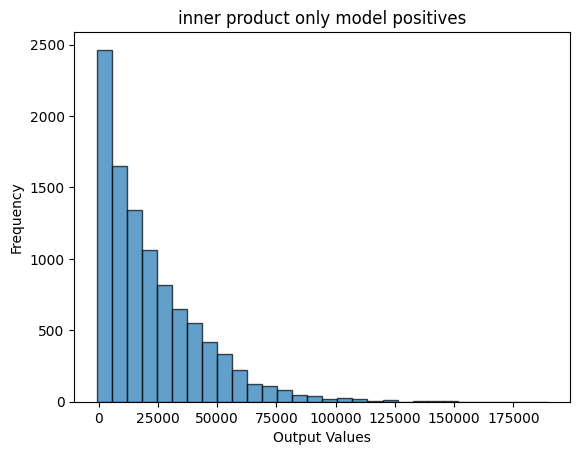

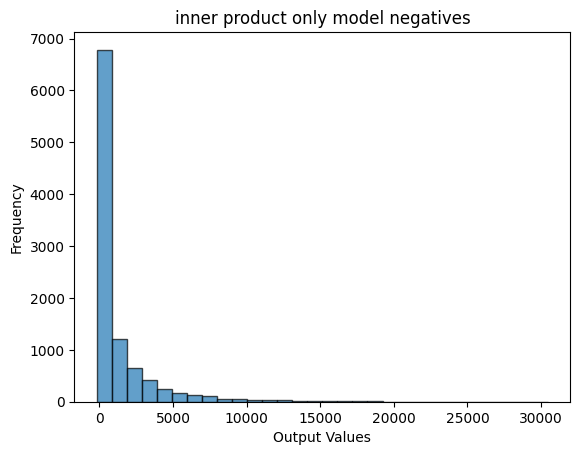

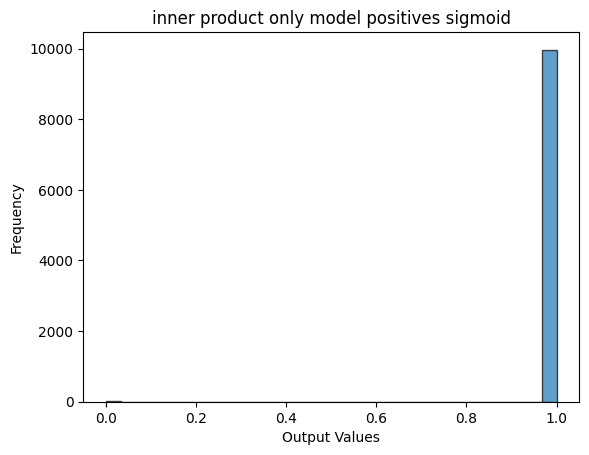

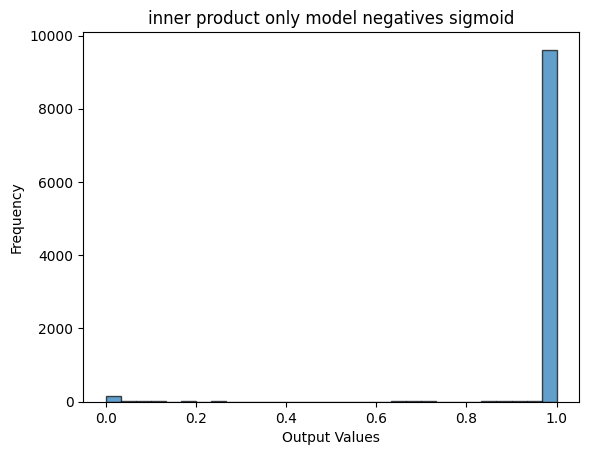

In [59]:
plot_histogram(o[:o.shape[0]//2], "inner product only model positives")
plot_histogram(o[o.shape[0]//2:], "inner product only model negatives")
plot_histogram(torch.sigmoid(o[:o.shape[0]//2]), "inner product only model positives sigmoid")
plot_histogram(torch.sigmoid(o[o.shape[0]//2:]), "inner product only model negatives sigmoid")

In [60]:
positives = o[:o.shape[0]//2]
negatives = o[o.shape[0]//2:]

pacc = (positives >= 0).float().sum() / positives.shape[0]
nacc = (negatives < 0).float().sum() / negatives.shape[0]
pacc * 0.5 + nacc*0.5

tensor(0.5114)

In [62]:
free_cuda_memory(model)

# Decision boundary

based on the diagram above, we decided to define the decision boundary of 0.7


In [38]:
save_model(model, datasets_path, "StyleMind-GCN, only inner product of embedding are used.")

NameError: name 'save_model' is not defined

In [ ]:
save_mod

#Adding bias to sigmoid inputs

In [34]:
import copy

In [35]:
model.reset_parameters()

losses = []
test_accs = []

best_test_acc = 0
best_model = None

optimizer = optim.Adam(model.parameters(), lr)
loss_fn = nn.BCEWithLogitsLoss()

x = x.to(device)
for epoch in range(NUM_EPOCHS):

    train_positives_eval_outfits, message_passing_edges = split_train_data(train_edge_index, 5)
    train_negatives_eval_outfits = negative_train_edge_index[torch.randperm(negative_train_edge_index.shape[0])[:train_positives_eval_outfits.shape[0]]]
    train_labels = torch.cat((torch.ones(train_positives_eval_outfits.shape[0]),
                              torch.zeros(train_negatives_eval_outfits.shape[0])))
    train_eval_outfits = torch.cat((train_positives_eval_outfits, train_negatives_eval_outfits), dim=0)
    train_loss = train(model, x, message_passing_edges.to(device)
    , train_eval_outfits.to(device), train_labels.to(device),
                       loss_fn=loss_fn, optimizer=optimizer)
    train_acc = test(model, x, message_passing_edges.to(device)
    , train_eval_outfits.to(device), train_labels.to(device))


    valid_message_passing_edges = torch.cat((concat_edge_indices(train_positives_eval_outfits)
    , message_passing_edges), dim=-1)
    valid_labels = torch.cat((torch.ones(valid_edge_index.shape[0]),
                              torch.zeros(valid_negative_samples.shape[0])))
    valid_eval_outfits = torch.cat((valid_edge_index, valid_negative_samples), dim=0)
    valid_acc = test(model, x, valid_message_passing_edges.to(device)
    , valid_eval_outfits.to(device), valid_labels.to(device))



    test_message_passing_edges = torch.cat((concat_edge_indices(valid_edge_index)
    , valid_message_passing_edges), dim=-1)
    test_labels = torch.cat((torch.ones(test_edge_index.shape[0]),
                              torch.zeros(test_negative_samples.shape[0])))
    test_eval_outfits = torch.cat((test_edge_index, test_negative_samples), dim=0)
    test_acc = test(model, x, test_message_passing_edges.to(device)
    , test_eval_outfits.to(device), test_labels.to(device))

    if(test_acc > best_test_acc):
        best_test_acc = test_acc
        best_model = copy.deepcopy(model)

    losses.append(train_loss)
    test_accs.append(test_acc)
    print(f'Epoch: {epoch:02d}, '
          f'Loss: {train_loss:.4f}, '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%')


Epoch: 00, Loss: 3.8664, Train: 50.00%, Valid: 50.00% Test: 49.99%
Epoch: 01, Loss: 9.1651, Train: 49.93%, Valid: 49.94% Test: 49.93%
Epoch: 02, Loss: 2.8556, Train: 49.95%, Valid: 49.96% Test: 49.97%
Epoch: 03, Loss: 2.9327, Train: 49.95%, Valid: 49.97% Test: 49.98%
Epoch: 04, Loss: 2.6509, Train: 49.93%, Valid: 49.97% Test: 49.97%
Epoch: 05, Loss: 2.0487, Train: 49.95%, Valid: 49.99% Test: 49.97%
Epoch: 06, Loss: 1.5795, Train: 49.95%, Valid: 49.96% Test: 49.97%
Epoch: 07, Loss: 1.2907, Train: 49.94%, Valid: 49.95% Test: 49.97%
Epoch: 08, Loss: 1.1198, Train: 49.96%, Valid: 49.99% Test: 49.97%
Epoch: 09, Loss: 1.0559, Train: 49.96%, Valid: 49.96% Test: 49.96%
Epoch: 10, Loss: 0.9901, Train: 49.96%, Valid: 49.97% Test: 49.97%
Epoch: 11, Loss: 0.9583, Train: 49.97%, Valid: 49.96% Test: 49.96%
Epoch: 12, Loss: 0.9466, Train: 49.95%, Valid: 49.98% Test: 49.96%
Epoch: 13, Loss: 0.9028, Train: 49.93%, Valid: 49.94% Test: 49.97%
Epoch: 14, Loss: 0.8368, Train: 49.92%, Valid: 49.93% Test: 49

In [36]:
best_test_acc

tensor(0.9144, device='cuda:0')

In [40]:
save_model(best_model, datasets_path, "StyleMind-GCN_biased_outputs.pth")

In [64]:
model = StyleMindGCN(in_channels, hidden_channels
                     ,out_channels, number_of_layers,"GCN", dropout, learning_margin=True).to(device)

model.load_state_dict(torch.load(path.join(datasets_path, "StyleMind-GCN_biased_outputs.pth")))

<All keys matched successfully>

In [43]:
best_model.final_prediction_margin

Parameter containing:
tensor(-2.1042, device='cuda:0', requires_grad=True)

In [82]:
datasplit = data_splits()


embd, o = model(x, datasplit['test']['message_passings'].to(device)
    , datasplit['test']['outfits'].to(device))
embd= embd.cpu()
o = o.cpu()

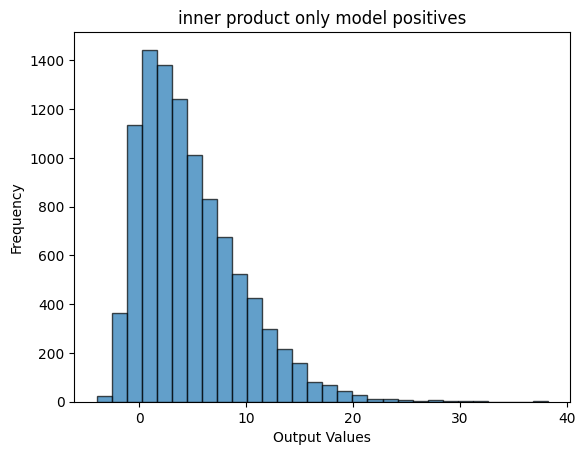

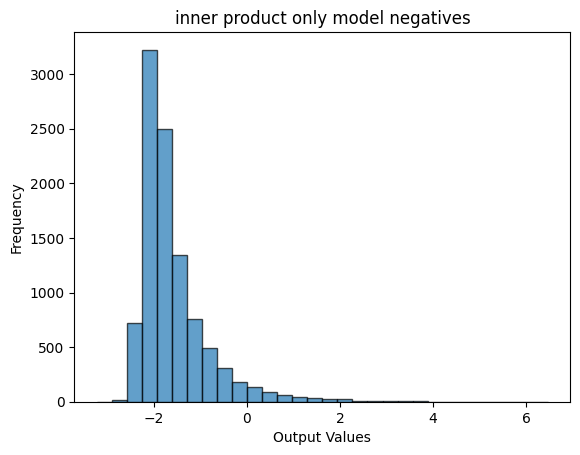

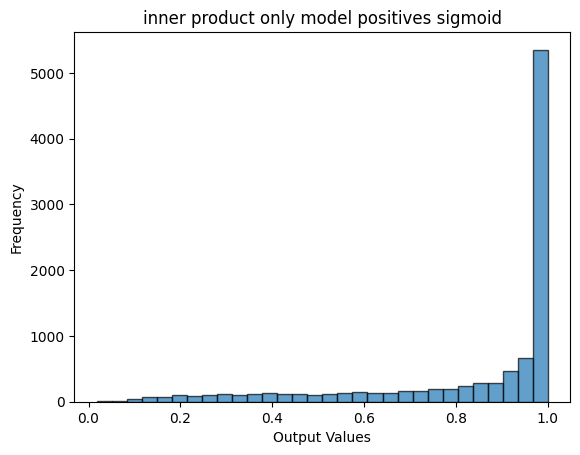

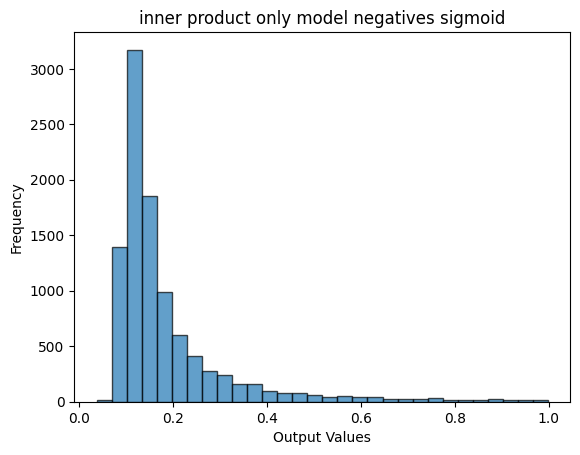

In [83]:
plot_histogram(o[:o.shape[0]//2], "inner product only model positives")
plot_histogram(o[o.shape[0]//2:], "inner product only model negatives")
plot_histogram(torch.sigmoid(o[:o.shape[0]//2]), "inner product only model positives sigmoid")
plot_histogram(torch.sigmoid(o[o.shape[0]//2:]), "inner product only model negatives sigmoid")

In [85]:
positives = o[:o.shape[0]//2]
negatives = o[o.shape[0]//2:]

pacc = (positives > 0).float().sum() / positives.shape[0]
nacc = (negatives <= 0).float().sum() / negatives.shape[0]
0.5*pacc + 0.5*nacc

tensor(0.9131)

In [55]:
positives = o[:o.shape[0]//2]
negatives = o[o.shape[0]//2:]

train_eval_outfits[positives.argmin()] ,train_eval_outfits[o.shape[0]//2+negatives.argmax()]

(tensor([[193375,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
              -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
              -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
              -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
              -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
              -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
              -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
              -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
              -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
              -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
              -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
              -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
              -1

In [134]:
# the worst false negatives
values, indices = torch.topk(negatives, 10, largest=True)

outfits = train_eval_outfits[(o.shape[0]//2)+indices][torch.where(train_eval_outfits[(o.shape[0]//2)+indices]>-1)]
number_of_garments_per_outfit = (train_eval_outfits[o.shape[0]//2+indices]>-1).float().sum(dim=(-1,-2))

outfits, number_of_garments_per_outfit
i = 0
result = []
for j in number_of_garments_per_outfit.int():
  result.append(set(outfits[i:i+j].tolist()))
  i += j

result = {k: [items.loc[items['index']==i]['ID'].item() for i in o]  for k,o in enumerate(result)}

import json

with open("worstFPs.json", "w") as f:
  json.dump(result, f, indent=4)

In [130]:
import json

# Read JSON from a file
with open("worstFPs.json", "r") as file:
    data = json.load(file)

print("JSON data:", data)


JSON data: {'0': [45768566, 143354527, 206299484, 183302521, 183236812], '1': [170301920, 132033877, 187498982, 158839785, 187950596, 191998015], '2': [80360383, 74588000, 126859205, 138180455, 205836766], '3': [41730249, 147883331, 147411023, 150737564, 189846447], '4': [161599256, 201458859, 68105585, 165502261, 150091405, 164826821, 101837389, 173597815], '5': [190811204, 145397682, 204542257, 211682911, 203154762], '6': [212764580, 150675438, 151380680, 179988294, 181104358], '7': [210473563, 167057560, 134389933, 65090075, 186155013, 127684739], '8': [197305654, 150495323, 132068063, 138667859, 174348662], '9': [166373789, 178782478, 212809241, 197241787, 157974990, 102523727, 47352111, 181333601]}


In [135]:
# the worst false positives
values, indices = torch.topk(positives, 10, largest=False)

outfits = train_eval_outfits[indices][torch.where(train_eval_outfits[indices]>-1)]
number_of_garments_per_outfit = (train_eval_outfits[indices]>-1).float().sum(dim=(-1,-2))

outfits, number_of_garments_per_outfit
i = 0
result = []
for j in number_of_garments_per_outfit.int():
  result.append(set(outfits[i:i+j].tolist()))
  i += j

result = {k: [items.loc[items['index']==i]['ID'].item() for i in o]  for k,o in enumerate(result)}

import json

with open("worstFNs.json", "w") as f:
  json.dump(result, f, indent=4)

In [104]:
ss = torch.randn(10).to(device)


a = set(ss.tolist())
a

{-0.9159104824066162,
 -0.3835882246494293,
 -0.30730435252189636,
 -0.17330965399742126,
 -0.16745677590370178,
 0.44133099913597107,
 0.7212685942649841,
 0.9103254675865173,
 0.9919949173927307,
 1.2212848663330078}

In [ ]:
# the worst false positives

In [47]:
import gc

gc.collect()
torch.cuda.empty_cache()

# train model with cosine similarities. (instead of simple inner product).

### the result are the same and the model is not certain about negative samples. in the other word the model, embeds the nodes, such that the negative samples are orthogonal in total.

## Pros:
  - faster convergance

##Cons:
  - more memory consuming.

In [ ]:
model.reset_parameters()

losses = []
test_accs = []

best_test_acc = 0
best_model = None

optimizer = optim.Adam(model.parameters(), lr)
loss_fn = nn.BCEWithLogitsLoss()

x = x.to(device)
for epoch in range(400):

    train_positives_eval_outfits, message_passing_edges = split_train_data(train_edge_index[:int(0.8*train_edge_index.shape[0])], 8)
    train_negatives_eval_outfits = negative_train_edge_index[torch.randperm(negative_train_edge_index.shape[0])[:train_positives_eval_outfits.shape[0]]]
    train_labels = torch.cat((torch.ones(train_positives_eval_outfits.shape[0]),
                              torch.zeros(train_negatives_eval_outfits.shape[0])))
    train_eval_outfits = torch.cat((train_positives_eval_outfits, train_negatives_eval_outfits), dim=0)
    train_loss = train(model, x, message_passing_edges.to(device)
    , train_eval_outfits.to(device), train_labels.to(device),
                       loss_fn=loss_fn, optimizer=optimizer)
    train_acc = test(model, x, message_passing_edges.to(device)
    , train_eval_outfits.to(device), train_labels.to(device))


    valid_message_passing_edges = torch.cat((concat_edge_indices(train_positives_eval_outfits)
    , message_passing_edges), dim=-1)
    valid_labels = torch.cat((torch.ones(valid_edge_index.shape[0]),
                              torch.zeros(valid_negative_samples.shape[0])))
    valid_eval_outfits = torch.cat((valid_edge_index, valid_negative_samples), dim=0)
    valid_acc = test(model, x, valid_message_passing_edges.to(device)
    , valid_eval_outfits.to(device), valid_labels.to(device))



    test_message_passing_edges = torch.cat((concat_edge_indices(valid_edge_index)
    , valid_message_passing_edges), dim=-1)
    test_labels = torch.cat((torch.ones(test_edge_index.shape[0]),
                              torch.zeros(test_negative_samples.shape[0])))
    test_eval_outfits = torch.cat((test_edge_index, test_negative_samples), dim=0)
    test_acc = test(model, x, test_message_passing_edges.to(device)
    , test_eval_outfits.to(device), test_labels.to(device))

    if(test_acc > best_test_acc):
        best_test_acc = test_acc
        best_model = copy.deepcopy(model)

    losses.append(train_loss)
    test_accs.append(test_acc)
    print(f'Epoch: {epoch:02d}, '
          f'Loss: {train_loss:.4f}, '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%')


Epoch: 00, Loss: 0.7318, Train: 50.00%, Valid: 50.00% Test: 50.00%
Epoch: 01, Loss: 0.7169, Train: 50.00%, Valid: 50.00% Test: 49.99%
Epoch: 02, Loss: 0.6912, Train: 50.00%, Valid: 50.00% Test: 50.00%
Epoch: 03, Loss: 0.6817, Train: 50.00%, Valid: 50.00% Test: 50.00%
Epoch: 04, Loss: 0.6740, Train: 50.00%, Valid: 50.00% Test: 50.00%
Epoch: 05, Loss: 0.6656, Train: 50.00%, Valid: 50.00% Test: 50.00%
Epoch: 06, Loss: 0.6569, Train: 50.00%, Valid: 50.00% Test: 50.00%
Epoch: 07, Loss: 0.6459, Train: 50.00%, Valid: 50.00% Test: 50.00%
Epoch: 08, Loss: 0.6404, Train: 50.00%, Valid: 50.00% Test: 50.00%
Epoch: 09, Loss: 0.6362, Train: 50.00%, Valid: 50.00% Test: 50.00%
Epoch: 10, Loss: 0.6301, Train: 50.00%, Valid: 50.00% Test: 50.00%
Epoch: 11, Loss: 0.6255, Train: 50.00%, Valid: 50.00% Test: 50.00%
Epoch: 12, Loss: 0.6209, Train: 50.00%, Valid: 50.00% Test: 50.00%
Epoch: 13, Loss: 0.6189, Train: 50.00%, Valid: 50.00% Test: 50.00%
Epoch: 14, Loss: 0.6142, Train: 50.00%, Valid: 50.00% Test: 50

KeyboardInterrupt: 

In [ ]:
best_test_acc

tensor(0.7587, device='cuda:0')

In [ ]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

In [ ]:
torch.cuda.reset_peak_memory_stats()
torch.cuda.reset_accumulated_memory_stats()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
m = x[:100].cpu()
m

tensor([[0.2134, 0.4643, 0.3334,  ..., 0.3668, 0.0379, 0.0898],
        [0.5982, 0.7184, 0.2694,  ..., 0.2122, 0.6592, 0.0720],
        [0.3819, 4.5064, 0.2355,  ..., 0.2252, 0.7095, 0.4182],
        ...,
        [0.4332, 1.0498, 0.8459,  ..., 0.1372, 0.1394, 0.4783],
        [0.2474, 0.4604, 0.6189,  ..., 0.0801, 0.5642, 1.3976],
        [1.7186, 0.4958, 0.3872,  ..., 0.2463, 0.6565, 0.0996]])

In [ ]:
get_node_embedding_with_mask_meaningless_edge_index_elements(x.cpu(), train_eval_outfits[:100])

In [ ]:
torch.cuda.empty_cache()

In [ ]:
best_test_acc.item()

0.757099986076355

In [39]:
def save_model(model, data_path, name):
  torch.save(model.state_dict(), path.join(data_path,name))

In [ ]:
save_model(best_model, datasets_path, "best_gcn_model_based_with_cosine.pth")
save_model(model, datasets_path, "last_gcn_model_based_with_cosine.pth")

In [ ]:
model.load_state_dict(torch.load(path.join(datasets_path,"last_gcn_model_based_with_cosine.pth")))

<All keys matched successfully>

In [ ]:
negative_train_edge_index.shape

torch.Size([53306, 2, 171])

In [ ]:
train_acc = test(model, x, message_passing_edges.to(device)
, train_eval_outfits.to(device), train_labels.to(device))

In [ ]:
embd, o = model(x, test_message_passing_edges.to(device)
, train_eval_outfits[14000:].to(device))

embd = embd.cpu()
o = o.cpu()



In [ ]:
train_eval_outfits[14000:][18]

tensor([[205458, 205458,  53235,  42435,  42435,  42435,     -1,     -1,     -1,
             -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
             -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
             -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
             -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
             -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
             -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
             -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
             -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
             -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
             -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
             -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
             -1,     -1,    

In [ ]:
items.loc[items['index'].isin([205458,  53235,  42435,9357])]

,Unnamed: 0,index,ID,url_name,description,catgeories,title,related,category_id,semantic_category,name_len
9357,9357,9357,213438505,fabulous in pink cluster earrings,NaN,NaN,NaN,NaN,11,jewellery,33
42435,42435,42435,35211694,notte marchesa silk-chiffon silk-organza halte...,NaN,NaN,NaN,NaN,1,all-body,51
53235,53235,53235,208070724,espadrilles with lacing 29.99,Yellow. Satin sandals with an adjustable strap...,"[""Women's Fashion"", 'Shoes', 'Sandals']",Sandals $24.99,"['Flats sandals', 'Yellow sandals', 'Rubber so...",6,shoes,29
205458,205458,205458,153558426,dolce gabbana sicily von crystal,NaN,NaN,NaN,NaN,5,bags,32


In [ ]:
torch.argmin(o)

tensor(3439)

In [ ]:
torch.argmax(o)

tensor(7257)

In [ ]:
indices = (o > 0.8).nonzero(as_tuple=True)
indices

(tensor([  18,  132,  159,  259,  439,  513,  711,  796, 1006, 1008, 1347, 1401,
         1462, 1580, 1594, 1630, 1647, 1692, 1772, 1790, 1825, 1841, 1905, 2251,
         2558, 2564, 2727, 2854, 3030, 3210, 3472, 3551, 3873, 4045, 4159, 4199,
         4279, 4412, 4535, 4649, 5113, 5183, 5217, 5224, 5333, 5385, 5436, 5480,
         5538, 5794, 5858, 5886, 5900, 5924, 6022, 6092, 6146, 6390, 6449, 6495,
         6498, 6562, 6634, 6776, 7019, 7092, 7257, 7272, 7309]),)

In [ ]:
o.shape, (o[o<0.5]).shape

(torch.Size([7322]), torch.Size([3653]))

In [ ]:
train_eval_outfits.shape

torch.Size([21322, 2, 171])

In [ ]:
node_embeddigns, o = best_model(x, test_message_passing_edges.to(device), test_eval_outfits.to(device))

o.shape

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.60 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.51 GiB is free. Process 69290 has 13.23 GiB memory in use. Of the allocated memory 11.11 GiB is allocated by PyTorch, and 1.99 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
import gc

gc.collect()
torch.cuda.empty_cache()

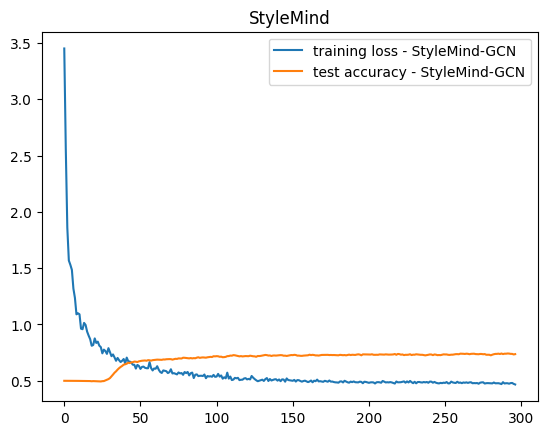

In [ ]:

plt.title("StyleMind")
plt.plot(losses[3:], label="training loss" + " - " + "StyleMind-GCN")
plt.plot(test_accs[3:], label="test accuracy" + " - " + "StyleMind-GCN")
plt.legend()
plt.show()


In [ ]:
mlp_model = StyleMindGCN(in_channels, hidden_channels
                     ,out_channels, number_of_layers,"MLP", dropout).to(device)

In [ ]:
mlp_model.reset_parameters()

losses = []
test_accs = []

best_test_acc = 0
best_mlp_model = None

optimizer = optim.Adam(mlp_model.parameters(), lr)
loss_fn = nn.BCELoss()

x = x.to(device)
for epoch in range(NUM_EPOCHS):

    train_positives_eval_outfits, message_passing_edges = split_train_data(train_edge_index, 5)
    train_negatives_eval_outfits = negative_train_edge_index[torch.randperm(negative_train_edge_index.shape[0])[:train_positives_eval_outfits.shape[0]]]
    train_labels = torch.cat((torch.ones(train_positives_eval_outfits.shape[0]),
                              torch.zeros(train_negatives_eval_outfits.shape[0])))
    train_eval_outfits = torch.cat((train_positives_eval_outfits, train_negatives_eval_outfits), dim=0)
    train_loss = train(mlp_model, x, message_passing_edges.to(device)
    , train_eval_outfits.to(device), train_labels.to(device),
                       loss_fn=loss_fn, optimizer=optimizer)
    train_acc = test(mlp_model, x, message_passing_edges.to(device)
    , train_eval_outfits.to(device), train_labels.to(device))


    valid_message_passing_edges = torch.cat((concat_edge_indices(train_positives_eval_outfits)
    , message_passing_edges), dim=-1)
    valid_labels = torch.cat((torch.ones(valid_edge_index.shape[0]),
                              torch.zeros(valid_negative_samples.shape[0])))
    valid_eval_outfits = torch.cat((valid_edge_index, valid_negative_samples), dim=0)
    valid_acc = test(mlp_model, x, valid_message_passing_edges.to(device)
    , valid_eval_outfits.to(device), valid_labels.to(device))



    test_message_passing_edges = torch.cat((concat_edge_indices(valid_edge_index)
    , valid_message_passing_edges), dim=-1)
    test_labels = torch.cat((torch.ones(test_edge_index.shape[0]),
                              torch.zeros(test_negative_samples.shape[0])))
    test_eval_outfits = torch.cat((test_edge_index, test_negative_samples), dim=0)
    test_acc = test(mlp_model, x, test_message_passing_edges.to(device)
    , test_eval_outfits.to(device), test_labels.to(device))

    if(test_acc > best_test_acc):
        best_test_acc = test_acc
        best_mlp_model = copy.deepcopy(mlp_model)

    losses.append(train_loss)
    test_accs.append(test_acc)
    print(f'Epoch: {epoch:02d}, '
          f'Loss: {train_loss:.4f}, '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%')


TypeError: Linear.forward() takes 2 positional arguments but 3 were given